In [483]:
import numpy as np  # linear algebra
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Загружаем датасет из файла, форируем модифицированный датасет с установленным индексом по ключу Symbol
data = pd.read_csv("C:/Programs/Projects/IPO/kaggle/input/financial-ipo-data/IPODataFull.csv", encoding="ISO-8859-1")
data_index = data.set_index('Symbol')
price_start_position = 8
price_stop_position = 1318
price_step = 5
roll_window = 5
diff_step = 2
trend_const = 10
profitably_const = 0.3


# Функция, которая формирует список price с ценами закрытий акций за все время наблюдений (263 дня)
def get_price(tmp_data):
    return tmp_data[8:1318:5]


# Функция, которая формирует список day_of_maxprice, содержащий номера дней, когда цена каждой акции была максимальна
def get_day_of_maxprice():
    day_of_mprice = []
    for num in range(data_index.shape[0]):
        price = get_price(data_index.iloc[num])
        day_of_mprice.append(price.index(max(price)) + 1)
    return day_of_mprice


# Функция, которая:
# 1. Формирует новый df,состоящий только из цен закрытия за все 262 дня
# 2. Заменяет каждое значение цены средним за предыдущие 5 дней
# 3. Вычисляет разницу 2-х значений усредненных цен с шагом 2, затем сумируем все разницы
# 3. Заменяет каждое значение получившейся серии по условию:
# если сумма отрицательная - бычий тренд, -1, больше 10 - медвежий, 1.
# В ином случае - считаем, что тренд невыраженный, нулевой (то есть за год цена значительно не выросла и не упала).
# После этого функция добавляет к входному датасету новый столбец Trend со значениями тренда
# Также функция добавляет столбец financialResult в котором отражено на сколько процентов изменилась цена
# и столбец is_profit как показатель прибыльности акции
def get_trend(input_df):
    df = input_df.iloc[:,price_start_position:price_stop_position:price_step].copy()
    df = df.rolling(roll_window, axis=1).mean()
    df = df.diff(diff_step, axis=1).sum(axis=1)
    df[df < 0] = -1
    df[(df > 0) & (df <= trend_const)] = 0
    df[df > trend_const] = 1
    df = df.astype(int)
    input_df['trend'] = df
    input_df['financialResult'] = (input_df['closeDay261'] - input_df['closeDay0']) / input_df['closeDay0']
    input_df['is_profit'] = input_df['financialResult'] >= profitably_const
    input_df.is_profit[input_df['is_profit']] = 1
    #input_df.is_profit[input_df['is_profit'] == False] = 0
    return 0

get_trend(data_index)
print (data_index)
#fig = plt.bar(list(dict(c).keys()), dict(c).values())
#fig = plt.gcf()
#fig.show

Columns (1342,1425,1432,1543,1546,1549,1551,1552,1553,1562,1587,1588,1605,1608,1615,1619,1620,1621,1622,1629,1630,1632,1633,1640,1641,1642,1643,1644,1646) have mixed types. Specify dtype option on import or set low_memory=False.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


        DaysBetterThanSP  daysProfit daysProfitGrouped  exactDiffernce  Year  \
Symbol                                                                         
A                    122         249              200+             NaN  1999   
AAC                  131         262              200+           232.0  2014   
AAOI                 125         262              200+          6054.0  2013   
AAP                  128         261              200+             NaN  2001   
AAT                  123         127         100 - 149           181.0  2011   
...                  ...         ...               ...             ...   ...   
ZUMZ                 139         261              200+             NaN  2005   
ZUO                    5           7            0 - 49             NaN  2018   
ZX                   102          25            0 - 49          1035.0  2011   
ZYME                 115          19            0 - 49             NaN  2017   
ZYNE                 104          42    

In [554]:
prepared_data = data_index[['MarketCap', 'Industry', 'Revenue', 'netIncome', ' lastFiscalYearGrowth ', 'employees', 
                            'YearFounded', 'is_profit']].copy()

prepared_data = prepared_data.replace(r'\$', '', regex=True)
prepared_data[['Revenue']] = prepared_data[['Revenue']].replace(' ', '', regex=True)
prepared_data[['Revenue']] = prepared_data[['Revenue']].replace(',', '.', regex=True)
prepared_data[['Revenue']] = prepared_data[['Revenue']].replace('\(', '', regex=True)
prepared_data[['Revenue']] = prepared_data[['Revenue']].replace('\)', '', regex=True)
prepared_data[['Revenue']] = prepared_data[['Revenue']].replace('B', '0000000', regex=True)
prepared_data[['Revenue']] = prepared_data[['Revenue']].replace('M', '0000', regex=True)
prepared_data[['Revenue']] = prepared_data[['Revenue']].replace('\.', '', regex=True).astype(float)

prepared_data[['netIncome']] = prepared_data[['netIncome']].replace(' ', '', regex=True)
prepared_data[['netIncome']] = prepared_data[['netIncome']].replace(',', '.', regex=True)
prepared_data[['netIncome']] = prepared_data[['netIncome']].replace('B', '0000000', regex=True)
prepared_data[['netIncome']] = prepared_data[['netIncome']].replace('M', '0000', regex=True)
prepared_data[['netIncome']] = prepared_data[['netIncome']].replace('\.', '', regex=True).astype(float)

prepared_data = prepared_data.fillna(0)

#prepared_data.Revenue[prepared_data['Revenue'] <= 0] = 1
prepared_data[['Revenue']] = np.log(prepared_data[['Revenue']])

#prepared_data[prepared_data['netIncome'] <= 0] = 1
#prepared_data = prepared_data.fillna(0)
prepared_data[['netIncome']] = np.log(prepared_data[['netIncome']])

prepared_data.rename(columns={" lastFiscalYearGrowth ": "lastFiscalYearGrowth"}, inplace=True)
prepared_data[['lastFiscalYearGrowth']] = prepared_data[['lastFiscalYearGrowth']].replace(' ', '', regex=True)
prepared_data[['lastFiscalYearGrowth']] = prepared_data[['lastFiscalYearGrowth']].replace('-', '0', regex=True)
prepared_data[['lastFiscalYearGrowth']] = prepared_data.lastFiscalYearGrowth.astype(float)
#prepared_data[prepared_data['lastFiscalYearGrowth'] <= 0] = 1
prepared_data[['lastFiscalYearGrowth']] = np.log(prepared_data[['lastFiscalYearGrowth']])

prepared_data[['Industry']] = prepared_data[['Industry']].astype(str)

prepared_data[['employees']] = prepared_data[['employees']].replace('-', '0', regex=True)
prepared_data[['employees']] = prepared_data[['employees']].astype(float)

prepared_data = prepared_data.replace([np.inf, -np.inf], np.nan)
prepared_data.fillna(0, inplace=True)
prepared_data

divide by zero encountered in log
invalid value encountered in log
divide by zero encountered in log
invalid value encountered in log
divide by zero encountered in log


,MarketCap,Industry,Revenue,netIncome,lastFiscalYearGrowth,employees,YearFounded,is_profit
Symbol,,,,,,,,
A,2.198323e+10,Biotechnology: Laboratory Analytical Instruments,22.220654,20.343468,-2.813411,13500.0,1999.0,0.0
AAC,2.707691e+08,Medical Specialities,19.576429,0.000000,-1.966113,2100.0,2014.0,1.0
AAOI,5.844368e+08,Semiconductors,19.761795,18.118900,-0.755023,3054.0,1997.0,1.0
AAP,7.874971e+09,Other Specialty Stores,22.960779,19.979898,0.000000,71000.0,1929.0,0.0
AAT,1.604956e+09,Real Estate Investment Trusts,19.557488,17.185561,-2.659260,194.0,2010.0,0.0
...,...,...,...,...,...,...,...,...
ZUMZ,6.085133e+08,Clothing/Shoe/Accessory Stores,20.647896,17.103912,0.000000,8900.0,1978.0,0.0
ZUO,2.132269e+09,0,18.939058,0.000000,0.000000,933.0,2007.0,0.0
ZX,6.711250e+07,Auto Parts:O.E.M.,19.853143,14.108180,-1.427116,0.0,2008.0,0.0


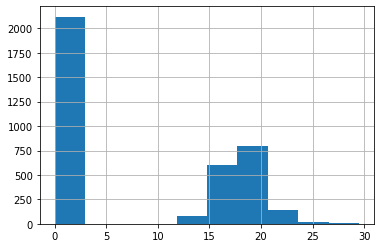

In [537]:
prepared_data.netIncome.hist()

In [558]:
prepared_data.isnull().sum()

MarketCap               0
Industry                0
Revenue                 0
netIncome               0
lastFiscalYearGrowth    0
employees               0
YearFounded             0
is_profit               0
dtype: int64

In [488]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [559]:
data_train = pd.get_dummies(prepared_data, columns =['MarketCap', 'Industry', 'Revenue', 'netIncome', 'lastFiscalYearGrowth', 'employees', 'YearFounded'])
data_train

,is_profit,MarketCap_0.0,MarketCap_79306.5215,MarketCap_102675.4,MarketCap_553874.04,MarketCap_842950.0,MarketCap_954567.9040000001,MarketCap_982430.0,MarketCap_1261403.64,MarketCap_1361930.4,...,YearFounded_2009.0,YearFounded_2010.0,YearFounded_2011.0,YearFounded_2012.0,YearFounded_2013.0,YearFounded_2014.0,YearFounded_2015.0,YearFounded_2016.0,YearFounded_2017.0,YearFounded_2018.0
Symbol,,,,,,,,,,,,,,,,,,,,,
A,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAC,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
AAOI,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAP,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAT,0.0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZUMZ,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZUO,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZX,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [560]:
X = data_train.iloc[:,1:]
X

,MarketCap_0.0,MarketCap_79306.5215,MarketCap_102675.4,MarketCap_553874.04,MarketCap_842950.0,MarketCap_954567.9040000001,MarketCap_982430.0,MarketCap_1261403.64,MarketCap_1361930.4,MarketCap_1452108.583,...,YearFounded_2009.0,YearFounded_2010.0,YearFounded_2011.0,YearFounded_2012.0,YearFounded_2013.0,YearFounded_2014.0,YearFounded_2015.0,YearFounded_2016.0,YearFounded_2017.0,YearFounded_2018.0
Symbol,,,,,,,,,,,,,,,,,,,,,
A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
AAOI,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAP,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAT,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZUMZ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZUO,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZX,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [561]:
y = data_train.iloc[:,0]
y.astype(int)

Symbol
A       0
AAC     1
AAOI    1
AAP     0
AAT     0
       ..
ZUMZ    0
ZUO     0
ZX      0
ZYME    0
ZYNE    0
Name: is_profit, Length: 3762, dtype: int32

In [562]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_test

,MarketCap_0.0,MarketCap_79306.5215,MarketCap_102675.4,MarketCap_553874.04,MarketCap_842950.0,MarketCap_954567.9040000001,MarketCap_982430.0,MarketCap_1261403.64,MarketCap_1361930.4,MarketCap_1452108.583,...,YearFounded_2009.0,YearFounded_2010.0,YearFounded_2011.0,YearFounded_2012.0,YearFounded_2013.0,YearFounded_2014.0,YearFounded_2015.0,YearFounded_2016.0,YearFounded_2017.0,YearFounded_2018.0
Symbol,,,,,,,,,,,,,,,,,,,,,
SRF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DSW,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GFN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MGNX,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRAX,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENTG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DDE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ROYT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [184]:
classifier = LogisticRegression(solver='lbfgs',random_state=0)
classifier.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [185]:
print('Accuracy: {:.2f}'.format(classifier.score(X_test, Y_test)))

Accuracy: 0.83


In [186]:
from sklearn.metrics import accuracy_score
predicted_y = classifier.predict(X_test)
predicted_y_proba = classifier.predict_proba(X_test)
predicted_y_proba[1,1]

0.16557903285027326

In [187]:
a = []
for i in range (len(Y_test)):
    if Y_test[i] == 1:
        a.append(predicted_y_proba[i,1])
a.sort()
a

[0.04338820990672947,
 0.05271936533313326,
 0.06000634893312231,
 0.061424848478259804,
 0.06614589252281428,
 0.07055428172127241,
 0.0705867944641493,
 0.07105570009193612,
 0.0735049996620741,
 0.07393416495666624,
 0.07417450442919876,
 0.07438715581571076,
 0.07482657785407679,
 0.07524351738352274,
 0.07763251737420719,
 0.07829555184126223,
 0.07998486702131301,
 0.08328374047166008,
 0.08382441242939496,
 0.08382441242939496,
 0.08391740971772181,
 0.08617325654049887,
 0.08624340870177707,
 0.08654910067015674,
 0.0908557147191726,
 0.09681564492867949,
 0.09931047787679777,
 0.10117946289662871,
 0.10368733507756563,
 0.1063606556563092,
 0.10667605869892192,
 0.11069234601090963,
 0.11716787480723659,
 0.12557121872008817,
 0.12731589430240156,
 0.12751599486880713,
 0.12852988809673874,
 0.130979176591538,
 0.13240828284302464,
 0.13737903679072114,
 0.14132218582371875,
 0.1423100580214671,
 0.14559758785008725,
 0.14611544325513134,
 0.1525844944454195,
 0.15356841809076

In [188]:
pd.Series(a).mean()

0.176246724133009

In [189]:
from sklearn.metrics import f1_score
f1_score(Y_test, predicted_y)

0.0125

In [190]:
predicted_y = classifier.predict(X_test)
pd.Series(predicted_y).value_counts()
#for x in range(len(predicted_y)):
#    if (predicted_y[x] == 1):
#        print(x, end="\t")

0.0    936
1.0      5
dtype: int64

In [191]:
from sklearn.model_selection import cross_val_score
from sklearn import tree

In [192]:
max_depth_values = range(1, 5)
scores_data = pd.DataFrame()

In [193]:
for max_depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    mean_cross_val_score = cross_val_score(clf, X_train, y_train, cv=5).mean()
    
    temp_score_data = pd.DataFrame({'max_depth': [max_depth], 
                                    'train_score': [train_score],
                                    'mean_cross_val_score': [mean_cross_val_score],
                                    'test_score': [test_score]})
    scores_data = scores_data.append(temp_score_data)

In [194]:
scores_data_long = pd.melt(scores_data, id_vars=['max_depth'], value_vars = ['train_score', 'test_score', 
                                                                             'mean_cross_val_score'],
                          var_name = 'set_type', value_name = 'score')

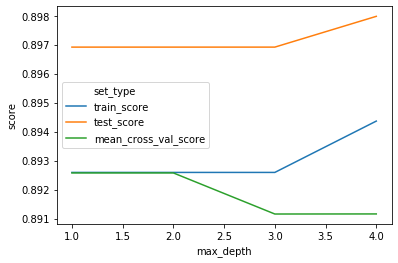

In [195]:
sns.lineplot(x = 'max_depth', y = 'score', hue = 'set_type', data = scores_data_long)

In [196]:
best_clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=2)
best_clf.fit(X_train, y_train)
y_pred = best_clf.predict(X_test)
pd.Series(y_pred).value_counts()

0.0    613
1.0    328
dtype: int64

In [106]:
155/(155+786)

0.1647183846971307

In [207]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [567]:
number_of_trees = range(1,50)
scores_data = pd.DataFrame()

In [568]:
for n_trees in number_of_trees:
    rf_clf = RandomForestClassifier(n_estimators=n_trees, 
                               bootstrap = True,
                               max_features = 'sqrt')
    rf_clf.fit(X_train, y_train)
    train_score = rf_clf.score(X_train, y_train)
    test_score = rf_clf.score(X_test, y_test)
    rf_probs = rf_clf.predict_proba(X_test)[:, 1]
    roc_value = roc_auc_score(y_test, rf_probs)
    mean_cross_val_score = cross_val_score(rf_clf, X_train, y_train, cv=5, scoring='roc_auc').mean()
    
    temp_score_data = pd.DataFrame({'number_of_trees': [n_trees], 
                                    'train_score': [train_score],
                                    'mean_cross_val_score': [mean_cross_val_score],
                                    'test_score': [test_score],
                                    'roc_auc_score': [roc_value]})
    scores_data = scores_data.append(temp_score_data)

In [569]:
scores_data_long = pd.melt(scores_data, id_vars=['number_of_trees'], value_vars = ['train_score', 'test_score', 
                                                                             'mean_cross_val_score', 'roc_auc_score'],
                          var_name = 'set_type', value_name = 'score')

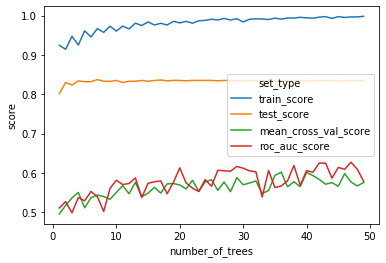

In [570]:
sns.lineplot(x = 'number_of_trees', y = 'score', hue = 'set_type', data = scores_data_long)

In [572]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
X1 = prepared_data.iloc[:,:7]
y1 = prepared_data.is_profit
labelencoder = LabelEncoder()
X1.iloc[:, 1] = labelencoder.fit_transform(X1.iloc[:, 1])
y1.astype(int)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=0)
X1.astype({'Industry': 'str'})
X1_train

,MarketCap,Industry,Revenue,netIncome,lastFiscalYearGrowth,employees,YearFounded
Symbol,,,,,,,
ENDP,1.219438e+09,69,0.000000,0.000000,0.000000,0.0,2013.0
MITT,4.849656e+08,0,18.558266,18.590930,0.000000,400.0,2011.0
ZOES,2.703145e+08,115,19.565222,0.000000,-1.966113,5473.0,1995.0
SNCR,5.521225e+08,42,19.982503,0.000000,0.000000,1765.0,2000.0
WBC,7.174430e+09,8,21.917188,19.822110,-1.714798,14631.0,1869.0
...,...,...,...,...,...,...,...
CVLT,3.085287e+09,30,20.293283,13.199324,-2.407946,2656.0,1996.0
STPP,4.168408e+06,27,0.000000,0.000000,0.000000,0.0,0.0
HTGM,9.300702e+07,17,16.507431,0.000000,0.631272,98.0,1997.0


In [577]:
pd.Series(y1_test).value_counts()

0.0    786
1.0    155
Name: is_profit, dtype: int64

In [605]:
best_rf_clf = RandomForestClassifier(n_estimators=46, 
                               bootstrap = True,
                               max_features = 'sqrt')
best_rf_clf.fit(X1_train, y1_train)
y1_pred = best_rf_clf.predict(X1_test)
pd.Series(y1_pred).value_counts()

0.0    913
1.0     28
dtype: int64

In [606]:
rf_prob = best_rf_clf.predict_proba(X1_test)[:, 1]
roc_value = roc_auc_score(y1_test, rf_prob)
roc_value

0.6263522941804154

In [607]:
mean_cross_val_score = cross_val_score(best_rf_clf, X1_train, y1_train, cv=5, scoring='roc_auc').mean()
mean_cross_val_score

0.6705059306110457

In [608]:
feats = {}
for feature, importance in zip(prepared_data.columns, best_rf_clf.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
importances

,Features,Gini-Importance
0,MarketCap,0.225707
1,Revenue,0.154844
2,employees,0.153095
3,Industry,0.138826
4,YearFounded,0.136494
5,netIncome,0.099712
6,lastFiscalYearGrowth,0.091321


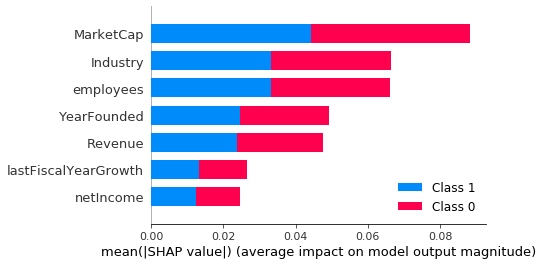

In [609]:
import shap

shap_test = shap.TreeExplainer(best_rf_clf.fit(X1_train, y1_train)).shap_values(X1_test)
shap.summary_plot(shap_test, X1_test,
                      max_display=25, plot_size=None)

In [475]:
explainer = shap.TreeExplainer(best_rf_clf.fit(X1_train, y1_train), X1_train)
shap_values = explainer(X1_train, check_additivity=False)
#shap.text_plot(shap_test)

100%|===================| 5641/5642 [00:47<00:00]        

In [476]:
shap_values[:,'MarketCap']

.values =
array([[ 0.03356755, -0.03356755],
       [ 0.00210729, -0.00210729],
       [ 0.06986363, -0.06986363],
       ...,
       [ 0.05102694, -0.05102694],
       [ 0.05203684, -0.05203685],
       [ 0.06458886, -0.06458886]])

.base_values =
array([[0.84431594, 0.15568406],
       [0.84431594, 0.15568406],
       [0.84431594, 0.15568406],
       ...,
       [0.84431594, 0.15568406],
       [0.84431594, 0.15568406],
       [0.84431594, 0.15568406]])

.data =
array([1.21943775e+09, 4.84965576e+08, 2.70314497e+08, ...,
       9.30070240e+07, 3.89740164e+08, 3.47327268e+08])

In [477]:
shap.plots.scatter(shap_values[:,'MarketCap'])

Exception: The passed Explanation object has multiple columns, please pass a single feature column to shap.plots.dependence like: shap_values[:,column]

In [478]:
shap.waterfall_plot(shap_values[0])

Exception: waterfall_plot requires a scalar base_values of the model output as the first parameter, but you have passed an array as the first parameter! Try shap.waterfall_plot(explainer.base_values[0], values[0], X[0]) or for multi-output models try shap.waterfall_plot(explainer.base_values[0], values[0][0], X[0]).

In [479]:
import xgboost

X, y = shap.datasets.adult()
model = xgboost.XGBClassifier().fit(X, y)

# compute SHAP values
explainer = shap.Explainer(model, X)
#shap_values = explainer(X[:1000])

NameError: name 'e' is not defined

In [497]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Загружаем датасет из файла, форируем модифицированный датасет с установленным индексом по ключу Symbol
data = pd.read_csv("C:/Programs/Projects/IPO/kaggle/input/financial-ipo-data/IPODataFull.csv", encoding="ISO-8859-1")
data_index = data.set_index('Symbol')
price_start_position = 8
price_stop_position = 1318
price_step = 5
roll_window = 5
diff_step = 2
trend_const = 10
profitably_const = 0.3


# Функция, которая формирует список price с ценами закрытий акций за все время наблюдений (263 дня)
def get_price(tmp_data):
    return tmp_data[price_start_position:price_stop_position:price_step]


# Функция, которая формирует список day_of_maxprice, содержащий номера дней, когда цена каждой акции была максимальна
def get_day_of_maxprice():
    day_of_mprice = []
    for num in range(data_index.shape[0]):
        price = get_price(data_index.iloc[num])
        day_of_mprice.append(price.index(max(price)) + 1)
    return day_of_mprice


# Функция, которая:
# 1. Формирует новый df,состоящий только из цен закрытия за все 262 дня
# 2. Заменяет каждое значение цены средним за предыдущие 5 дней
# 3. Вычисляет разницу 2-х значений усредненных цен с шагом 2, затем сумируем все разницы
# 3. Заменяет каждое значение получившейся серии по условию:
# если сумма отрицательная - бычий тренд, -1, больше 10 - медвежий, 1.
# В ином случае - считаем, что тренд невыраженный, нулевой (то есть за год цена значительно не выросла и не упала).
# После этого функция добавляет к входному датасету новый столбец Trend со значениями тренда
# Также функция добавляет столбец financialResult в котором отражено на сколько процентов изменилась цена
# и столбец is_profit как показатель прибыльности акции
def get_trend(input_df):
    df = input_df.iloc[:,price_start_position:price_stop_position:price_step].copy()
    df = df.rolling(roll_window, axis=1).mean()
    df = df.diff(diff_step, axis=1).sum(axis=1)
    df[df < 0] = -1
    df[(df > 0) & (df <= trend_const)] = 0
    df[df > trend_const] = 1
    df = df.astype(int)
    input_df['trend'] = df
    input_df['financialResult'] = (input_df['closeDay261'] - input_df['closeDay0']) / input_df['closeDay0']
    input_df['is_profit'] = input_df['financialResult'] >= profitably_const
    input_df.is_profit[input_df['is_profit']] = 1
    return 0


# Функция предобработки данных. Вычищает спецсимволы, пробелы, приводит численные колонки к типу float,
# убирает пустые значения
def prepare_data(input_df):
    prepared_data = input_df[['MarketCap', 'Industry', 'Revenue', 'netIncome', ' lastFiscalYearGrowth ',
                              'employees', 'YearFounded', 'is_profit']].copy()

    prepared_data = prepared_data.replace(r'\$', '', regex=True)
    prepared_data[['Revenue']] = prepared_data[['Revenue']].replace(' ', '', regex=True)
    prepared_data[['Revenue']] = prepared_data[['Revenue']].replace(',', '.', regex=True)
    prepared_data[['Revenue']] = prepared_data[['Revenue']].replace(r'\(', '', regex=True)
    prepared_data[['Revenue']] = prepared_data[['Revenue']].replace(r'\)', '', regex=True)
    prepared_data[['Revenue']] = prepared_data[['Revenue']].replace('B', '0000000', regex=True)
    prepared_data[['Revenue']] = prepared_data[['Revenue']].replace('M', '0000', regex=True)
    prepared_data[['Revenue']] = prepared_data[['Revenue']].replace(r'\.', '', regex=True).astype(float)

    prepared_data[['netIncome']] = prepared_data[['netIncome']].replace(' ', '', regex=True)
    prepared_data[['netIncome']] = prepared_data[['netIncome']].replace(',', '.', regex=True)
    prepared_data[['netIncome']] = prepared_data[['netIncome']].replace('B', '0000000', regex=True)
    prepared_data[['netIncome']] = prepared_data[['netIncome']].replace('M', '0000', regex=True)
    prepared_data[['netIncome']] = prepared_data[['netIncome']].replace(r'\.', '', regex=True).astype(float)

    prepared_data.rename(columns={" lastFiscalYearGrowth ": "lastFiscalYearGrowth"}, inplace=True)
    prepared_data[['lastFiscalYearGrowth']] = prepared_data[['lastFiscalYearGrowth']].replace(' ', '', regex=True)
    prepared_data[['lastFiscalYearGrowth']] = prepared_data[['lastFiscalYearGrowth']].replace('-', '0', regex=True)
    prepared_data[['lastFiscalYearGrowth']] = prepared_data.lastFiscalYearGrowth.astype(float)

    prepared_data[['Industry']] = prepared_data[['Industry']].astype(str)

    prepared_data[['employees']] = prepared_data[['employees']].replace('-', '0', regex=True)
    prepared_data[['employees']] = prepared_data[['employees']].astype(float)

    prepared_data.fillna(-9999, inplace=True)
    return prepared_data


def split_data(input_df):
    x = input_df.iloc[:, :7]
    y = input_df.is_profit
    label_encoder = LabelEncoder()
    x.iloc[:, 1] = label_encoder.fit_transform(x.iloc[:, 1])
    y.astype(int)
    x_train, x_test, y_tr, y_tes = train_test_split(x, y, random_state=0)
    return X_train, X_test, y_tr, y_tes


get_trend(data_index)
prepared_df = prepare_data(data_index)

X_train, X_test, y_train, y_test = split_data(prepared_df)

rf_clf = RandomForestClassifier()
n_estimators = [int(x) for x in np.linspace(start=10, stop=100, num=10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start=1, stop=15, num=15)]
min_samples_split = [int(x) for x in np.linspace(start=2, stop=50, num=10)]
min_samples_leaf = [int(x) for x in np.linspace(start=2, stop=50, num=10)]
bootstrap = [True, False]
param = {'n_estimators': n_estimators,
         'max_features': max_features,
         'max_depth': max_depth,
         'min_samples_split': min_samples_split,
         'min_samples_leaf': min_samples_leaf,
         'bootstrap': bootstrap}
rf_clf_search = GridSearchCV(rf_clf, param_grid=param, n_jobs=-1, cv=3,
                             verbose=1)
rf_clf_search.fit(X_train, y_train)
best_rf_clf = rf_clf_search.best_estimator_
#best_rf_clf.predict(X_test)

rf_prob = best_rf_clf.predict_proba(X_test)[:, 1]
roc_value = roc_auc_score(y_test, rf_prob)
print(roc_value)


Columns (1342,1425,1432,1543,1546,1549,1551,1552,1553,1562,1587,1588,1605,1608,1615,1619,1620,1621,1622,1629,1630,1632,1633,1640,1641,1642,1643,1644,1646) have mixed types. Specify dtype option on import or set low_memory=False.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fitting 3 folds for each of 60000 candidates, totalling 180000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

0.655286054338012


In [498]:
rf_clf_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=23,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [626]:
import optuna

def objective(trial):

    rf_n_estimators = trial.suggest_int("rf_n_estimators", 2, 100)
    rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32)
    rf_min_samples_split = trial.suggest_int("rf_min_samples_split", 2, 50)
    rf_min_samples_leaf = trial.suggest_int("rf_min_samples_leaf", 2, 50)
    rf_max_features = trial.suggest_categorical("rf_max_features", ["log2", "sqrt"])
    rf_bootstrap = trial.suggest_categorical("rf_bootstrap", ["True", "False"])

    classifier_obj = RandomForestClassifier(max_depth=rf_max_depth, 
                                            n_estimators=rf_n_estimators, 
                                            min_samples_split=rf_min_samples_split, 
                                            min_samples_leaf=rf_min_samples_leaf, 
                                            max_features=rf_max_features, 
                                            bootstrap=rf_bootstrap)

    score = cross_val_score(classifier_obj, X1_train, y1_train, n_jobs=-1, cv=5, scoring='roc_auc')
    accuracy = score.mean()
    return accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print(study.best_params)

[I 2020-11-13 16:01:29,783] A new study created in memory with name: no-name-9dc5b9fe-666e-4aef-943f-77d721e3de0b
[I 2020-11-13 16:01:32,128] Trial 0 finished with value: 0.6714515287436779 and parameters: {'rf_n_estimators': 15, 'rf_max_depth': 9, 'rf_min_samples_split': 14, 'rf_min_samples_leaf': 6, 'rf_max_features': 'sqrt', 'rf_bootstrap': 'True'}. Best is trial 0 with value: 0.6714515287436779.
[I 2020-11-13 16:01:33,519] Trial 1 finished with value: 0.6945557888722353 and parameters: {'rf_n_estimators': 50, 'rf_max_depth': 29, 'rf_min_samples_split': 39, 'rf_min_samples_leaf': 19, 'rf_max_features': 'log2', 'rf_bootstrap': 'False'}. Best is trial 1 with value: 0.6945557888722353.
[I 2020-11-13 16:01:33,824] Trial 2 finished with value: 0.697456024049594 and parameters: {'rf_n_estimators': 90, 'rf_max_depth': 9, 'rf_min_samples_split': 45, 'rf_min_samples_leaf': 28, 'rf_max_features': 'sqrt', 'rf_bootstrap': 'True'}. Best is trial 2 with value: 0.697456024049594.
[I 2020-11-13 16:

[I 2020-11-13 16:01:42,614] Trial 27 finished with value: 0.6461429641330934 and parameters: {'rf_n_estimators': 2, 'rf_max_depth': 26, 'rf_min_samples_split': 20, 'rf_min_samples_leaf': 26, 'rf_max_features': 'sqrt', 'rf_bootstrap': 'True'}. Best is trial 22 with value: 0.7003433595996922.
[I 2020-11-13 16:01:43,033] Trial 28 finished with value: 0.6980207680529043 and parameters: {'rf_n_estimators': 83, 'rf_max_depth': 22, 'rf_min_samples_split': 44, 'rf_min_samples_leaf': 33, 'rf_max_features': 'sqrt', 'rf_bootstrap': 'True'}. Best is trial 22 with value: 0.7003433595996922.
[I 2020-11-13 16:01:43,504] Trial 29 finished with value: 0.6951907310232079 and parameters: {'rf_n_estimators': 92, 'rf_max_depth': 19, 'rf_min_samples_split': 29, 'rf_min_samples_leaf': 39, 'rf_max_features': 'sqrt', 'rf_bootstrap': 'True'}. Best is trial 22 with value: 0.7003433595996922.
[I 2020-11-13 16:01:44,040] Trial 30 finished with value: 0.699624934205403 and parameters: {'rf_n_estimators': 79, 'rf_ma

[I 2020-11-13 16:01:55,923] Trial 54 finished with value: 0.6913099115671153 and parameters: {'rf_n_estimators': 100, 'rf_max_depth': 28, 'rf_min_samples_split': 33, 'rf_min_samples_leaf': 11, 'rf_max_features': 'sqrt', 'rf_bootstrap': 'True'}. Best is trial 22 with value: 0.7003433595996922.
[I 2020-11-13 16:01:56,299] Trial 55 finished with value: 0.6991587710626618 and parameters: {'rf_n_estimators': 95, 'rf_max_depth': 24, 'rf_min_samples_split': 2, 'rf_min_samples_leaf': 20, 'rf_max_features': 'sqrt', 'rf_bootstrap': 'True'}. Best is trial 22 with value: 0.7003433595996922.
[I 2020-11-13 16:01:56,762] Trial 56 finished with value: 0.69645614994824 and parameters: {'rf_n_estimators': 95, 'rf_max_depth': 21, 'rf_min_samples_split': 4, 'rf_min_samples_leaf': 24, 'rf_max_features': 'sqrt', 'rf_bootstrap': 'True'}. Best is trial 22 with value: 0.7003433595996922.
[I 2020-11-13 16:01:57,151] Trial 57 finished with value: 0.7002658255657982 and parameters: {'rf_n_estimators': 79, 'rf_max

[I 2020-11-13 16:02:09,146] Trial 82 finished with value: 0.6986489969973588 and parameters: {'rf_n_estimators': 81, 'rf_max_depth': 23, 'rf_min_samples_split': 44, 'rf_min_samples_leaf': 22, 'rf_max_features': 'log2', 'rf_bootstrap': 'True'}. Best is trial 69 with value: 0.700502714505023.
[I 2020-11-13 16:02:09,639] Trial 83 finished with value: 0.6928159921007622 and parameters: {'rf_n_estimators': 76, 'rf_max_depth': 20, 'rf_min_samples_split': 46, 'rf_min_samples_leaf': 15, 'rf_max_features': 'log2', 'rf_bootstrap': 'True'}. Best is trial 69 with value: 0.700502714505023.
[I 2020-11-13 16:02:09,910] Trial 84 finished with value: 0.6974936945950694 and parameters: {'rf_n_estimators': 51, 'rf_max_depth': 24, 'rf_min_samples_split': 42, 'rf_min_samples_leaf': 24, 'rf_max_features': 'log2', 'rf_bootstrap': 'True'}. Best is trial 69 with value: 0.700502714505023.
[I 2020-11-13 16:02:10,281] Trial 85 finished with value: 0.6937200877156988 and parameters: {'rf_n_estimators': 65, 'rf_max

{'rf_n_estimators': 76, 'rf_max_depth': 22, 'rf_min_samples_split': 47, 'rf_min_samples_leaf': 25, 'rf_max_features': 'log2', 'rf_bootstrap': 'True'}
